# Desafío 01

## Integrantes

- Acevedo Zain, Gaspar (acevedo.zain.gaspar@gmail.com)

## Consignas

**Cada experimento realizado debe estar acompañado de una explicación o interpretación de lo observado.**

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Construir un modelo de clasificación por prototipos (tipo zero-shot). Clasificar los documentos de un conjunto de test comparando cada uno con todos los de entrenamiento y asignar la clase al label del documento del conjunto de entrenamiento con mayor similaridad.

**3**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**NO cambiar el hiperparámetro ngram_range de los vectorizadores**.

**4**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares.

**Elegir las palabras MANUALMENTE para evitar la aparición de términos poco interpretables**.


## Imports y carga de datos

In [ ]:
%pip install numpy scikit-learn

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_20newsgroups

from sklearn.utils import Bunch
from scipy.sparse import csr_matrix, csc_matrix

from sklearn.model_selection import GridSearchCV

from typing import Tuple, Any
import random

In [ ]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

## ***Resolución ejercicio 1***

***Enunciado***

- Vectorizar documentos.
- Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
- Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

### Definición de corpus y documentos con los que se trabajarán

Comenzamos inicializando un vectorizador del tipo [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) con los parámetros por defecto.

In [106]:
tfidVectorizer_01 = TfidfVectorizer()

Una vez inicializado el vectorizador, se procede a vectorizar el set de entrenamiento (`newsgroups_train`).

In [107]:
X_train = tfidVectorizer_01.fit_transform(newsgroups_train.data)

Se muestra que hay $11314$ documentos vectorizados en el set de entrenamiento.

In [108]:
cant_docs = X_train.shape[0]
print(f"Cantidad de documentos en train: {cant_docs}")

Cantidad de documentos en train: 11314


Se muestra que el tamaño del vocabulario en el set de entrenamiento es de $101631$.

In [109]:
tam_vocab = X_train.shape[1]
print(f"Tamaño del vocabulario en train: {tam_vocab}")

Tamaño del vocabulario en train: 101631


Se crea a continuación un diccionario que va de índices a términos (código dado por la materia).

In [110]:
idx2word = {v: k for k,v in tfidVectorizer_01.vocabulary_.items()}

A continuación, se seleccionan al azar $5$ documentos vectorizados del set de entrenamiento.

In [111]:
# random_idxs = [random.randint(0, cant_docs -1) for _ in range(5)]

In [112]:
random_idxs = [11097, 3377, 8880, 7332, 1293]

In [113]:
corpus = newsgroups_train

### Funciones de utilidad

Se definen las siguientes funciones de utilidad:

- `get_documents_similarity`, la cual, dados una `matriz documento-término` y un índice de un documento de la misma, obtiene la `similitud coseno` entre dicho documento y el resto de los documentos de la matriz, como así también los índices de estos documentos.
- `get_k_most_similar_documents`, la cual utiliza la función anterior, y devuelve a los $K$ documentos con mayor `similitud coseno` junto a sus índices. Por defecto $K = 5$.
- `imprimir_informe`, la cual devuelve un informe de un documento de un corpus, al cual se compara utilizando la similitud coseno con otros documentos del corpus.
- `get_common_words`, la cual devuelve los términos que tienen en común dos documentos vectorizados.

In [ ]:
def get_documents_similarity(matriz_dt: csr_matrix, idx: int) -> Tuple[np.ndarray, np.ndarray]:
  """
  Devuelve la similitud coseno de un documento respecto al resto de los
    documentos de una matriz documento-término.

  Args:
    matriz_dt (csr_matrix): Matrix documento-término a partir de la cual se
      obtendrá la similitud coseno de un documento, dado su índice.
    idx (int): índice del documento sobre el cual se trabajará.
  Returns:
    Tuple[np.ndarray, np.ndarray]:
      Elem 0: documentos ordenados de mayor a menor similitud coseno.
      Elem 1: argumentos correspondientes a Elem 0.
  Raises:
    IndexError, si el parámetro `idx` está fuera del rando de índices de
      `matriz_dt`.
  """

  if idx >= matriz_dt.shape[0]:
    raise IndexError(f"El parámetro `idx` está fuera del rango del corpus \
    ({matriz_dt.shape[0]}).")

  documents_similarity = cosine_similarity(matriz_dt[idx], matriz_dt)[0]

  sorted_docs = np.sort(documents_similarity)[::-1]
  arg_docs = np.argsort(documents_similarity)[::-1]
  return sorted_docs, arg_docs


In [ ]:
def get_k_most_similar_documents(matriz_dt: csr_matrix, idx: int, K: int = 5) -> Tuple[np.ndarray, np.ndarray]:
  """
  Dado una matríz documento-término y un índice correspondiente a uno de sus documentos, devuelve
  los K documentos con mayor similitud coseno respecto del documento indicado.

  Args:
    matriz_dt (csr_matrix): Matrix documento-término a partir de la cual se
      obtendrá la similitud coseno de un documento, dado su índice.
    idx (int): índice del documento sobre el cual se trabajará.
    K (int): número de documentos con mayor similitud que se quiere encontrar.
      Por defecto es 5.
  Returns:
    np.ndarray: array de longitud K que contiene la similitud coseno del
      documento a analizar respecto al resto, ordenados de mayor a menor.
    Tuple[np.ndarray, np.ndarray]:
      Elem 0: `K` documentos ordenados de mayor a menor similitud coseno.
      Elem 1: argumentos correspondientes a Elem 0.
  Raises:
    IndexError, si el parámetro `idx` está fuera del rando de índices de
      `matriz_dt`.
  """

  if idx >= matriz_dt.shape[0]:
    raise IndexError(f"El parámetro `idx` está fuera del rango de la matriz \
    documento-término ({matriz_dt.shape[0]}).")

  docs_similarity, docs_args = get_documents_similarity(matriz_dt=matriz_dt, idx=idx)

  # El índice 0 corresponde al propio documento
  return docs_similarity[1:K + 1], docs_args[1:K + 1]

In [ ]:
def imprimir_informe(corpus: Bunch, idx: int, similar_docs: np.ndarray, similar_docs_idxs: np.ndarray) -> str:
  """
  Esta función permite mostrar un informe correspondiente al documento de un
  corpus dado, en donde se muestran los K documentos con mayor similitud coseno.

  Args:
    corpus (Bunch): corpus sobre el cual se trabaja.
    idx (int): índice del documento sobre el cual se hace el análisis.
    similar_docs (np.ndarray): array que contiene los K documentos con mayor
      similitud coseno respecto del documento de análisis.
    similar_docs_idxs (np.ndarray): array que contiene los índices correspondientes
      a los documentos de `similar_docs`.

  Returns:
    string: Informe, con tabla comparativa de documentos.
  """
  doc_data = corpus.data[idx]
  doc_target_idx = corpus.target[idx]
  doc_type = corpus.target_names[doc_target_idx]

  informe = f"En esta sección se realiza el análisis del documento con índice ${idx}$\n\n"
  informe += f"Este es un documento del tipo `{doc_type}`.\n\n"
  informe += f"A continuación, se muestran los  5  documentos con mayor similitud coseno, dentro del corpus de ***entrenamiento***.\n\n"

  tabla_comparativa = f"| Índice documento | Tipo de documento | Similitud coseno con documento ${idx}$ | Coinciden los tipos de documento? |\n"
  tabla_comparativa += f"| --- | --- | --- | --- |\n"

  for i in range(len(similar_docs)):
    # Similitud coseno entre documentos
    similarity = similar_docs[i]
    # Índice dentro del corpus del documento con el cual se comparó
    similarity_idx = similar_docs_idxs[i]
    # Índice del tipo de documento contra el cual se comparó
    similarity_target_idx = corpus.target[similarity_idx]
    # Tipo de documento contra el cual se comparó
    similarity_type = corpus.target_names[similarity_target_idx]

    same_type = "Si" if doc_type == similarity_type else "No"

    tabla_comparativa += f"| ${similarity_idx}$ | {similarity_type} | ${np.round(similarity, 4)}$ | {same_type} |\n"

  return informe + tabla_comparativa

In [ ]:
def get_common_words(vectorized_corpus: csr_matrix, idx1: int, idx2: int, idx2word: dict) -> list:
  """
  Devuelve los términos comunes de dos documentos vectorizados.

  Args:
    vectorized_corpus (csr_matrix): Corpus (vectorizado) al que corresponden
      los documentos.
    idx1 (int): índice dentro del vectorized corpus del primer documento.
    idx2 (int): índice dentro del vectorized corpus del segundo documento.
    idx2word: diccionario que va de índices a términos del corpus.

  Returns:
    list: lista con términos en común.
  """
  # Términos del documento 1 (o documento base)
  _, cols1 = (vectorized_corpus[idx1]).nonzero()
  # Términos del documento 2
  _, cols2 = (vectorized_corpus[idx2]).nonzero()

  # Los trato como `sets` para facilitar la `intersección`
  cols1set = set(cols1)
  cols2set = set(cols2)
  common_cols = list(cols1set.intersection(cols2set))

  common_words = []

  for col in common_cols:
    common_words.append(idx2word[col])

  return common_words

### Análisis del documento con índice $11097$

En esta sección se realiza el análisis del documento con índice $11097$

Este es un documento del tipo `soc.religion.christian`.

A continuación, se muestran los  5  documentos con mayor similitud coseno, dentro del corpus de ***entrenamiento***.

| Índice documento | Tipo de documento | Similitud coseno con documento $11097$ | Coinciden los tipos de documento? |
| --- | --- | --- | --- |
| $4626$ | soc.religion.christian | $0.2651$ | Si |
| $11117$ | soc.religion.christian | $0.2036$ | Si |
| $7358$ | talk.religion.misc | $0.2027$ | No |
| $4800$ | soc.religion.christian | $0.2022$ | Si |
| $8807$ | talk.religion.misc | $0.1759$ | No |

Algo a remarcar es que, si bien los resultados de la similitud coseno son *bajos*, la mayoría de los documentos ***SI*** coinciden en `tipo`. A priori, podemos decir que no es una buena métrica para clasificar documentos.

In [ ]:
idx = random_idxs[0]
similar_docs, similar_docs_idx = get_k_most_similar_documents(matriz_dt=X_train, idx=idx)
informe = imprimir_informe(corpus=corpus, idx=idx, similar_docs=similar_docs, similar_docs_idxs=similar_docs_idx)

In [ ]:
print(informe)

En esta sección se realiza el análisis del documento con índice $11097$

Este es un documento del tipo `soc.religion.christian`.

A continuación, se muestran los  5  documentos con mayor similitud coseno, dentro del corpus de ***entrenamiento***.

| Índice documento | Tipo de documento | Similitud coseno con documento $11097$ | Coinciden los tipos de documento? |
| --- | --- | --- | --- |
| $4626$ | soc.religion.christian | $0.2651$ | Si |
| $11117$ | soc.religion.christian | $0.2036$ | Si |
| $7358$ | talk.religion.misc | $0.2027$ | No |
| $4800$ | soc.religion.christian | $0.2022$ | Si |
| $8807$ | talk.religion.misc | $0.1759$ | No |



Como se puede observar, para el primer documento analizado, el cual tiene el índice $11097$, de los $5$ documentos con mayor similitud coseno se encontró que $3$ de ellos tienen el mismo tipo (`soc.religion.christian`), mientras que el resto no, aunque son de una *temática* similar (`talk.religion.misc`).

A continuación se muestra el contenido de todos los documentos utilizados en esta comparación.

#### Comparaciones entre documentos

Contenido del documento analizado/documento base (índice $11097$)

- Tipo de documento: `soc.religion.christian`.

Como se puede observar, aparecen *términos* como **God**, **Heaven**, **mercy**, lo cual dan a entender que es un documento que referencia a la fe Cristiana (de ahí su tipo).

In [ ]:
print(corpus.data[idx])


I have also heard it called an expression of mercy, because Heaven would be
far more agonizing for those who had rejected God.



Contenido del documento con índice $4626$:
- Similitud coseno: $0.2651$.
- Tipo de documento: `soc.religion.christian`.
- Tiene el mismo tipo que el documento base?: ***Si***.

En este documento aparecen los términos **God**, **mercy** y **Hell**, el cual da a enteder que es un documento que referencia a la fe Cristiana (tipo `soc.religion.christian`).

Los términos en común con el documento base son: `god`, `be`, `an`, `expression`, `mercy`, `of`, `because`.

Varios de estos términos podrían aportar poco valor (`be`, `an`), ya que suelen repetirse en documentos de distinto tipo dentro del corpus, pero los que sí podrían aportar bastante valor son `god` y `mercy`.

In [ ]:
print(corpus.data[similar_docs_idx[0]])

Quoth the Moderator:


In a short poem ("God in His mercy made / the fixed pains of Hell"),
C. S. Lewis expresses an idea that I'm sure was current among others,
but I haven't be able to find its source:

that even Hell is an expression of mercy, because God limits the amount
of separation from Him, and hence the amount of agony, that one can
achieve.



In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[0], idx2word=idx2word)
print(common_words)


['god', 'be', 'an', 'expression', 'mercy', 'of', 'because']


Contenido del documento con índice $11117$:
- Similitud coseno: $0.2036$.
- Tipo de documento: `soc.religion.christian`.
- Tiene el mismo tipo que el documento base?: ***Si***.

En este documento aparecen los términos **God**, **Heaven**, **faith**, **christians**, entre otros, los cuales dan a enteder que es un documento que referencia a la fe Cristiana (tipo `soc.religion.christian`).

Los términos en común con el documento base son: `god`, `be`, `heaven`, `who`, `would`, `of`, `because`, `have`, `it`.

In [ ]:
print(corpus.data[similar_docs_idx[1]])

Here's how I talk to non-Christians who are complaining about Hell.

ME:	"Do you believe you're going to Heaven?"
HIM:	"I don't believe in Heaven."
ME:	"So are you going there?"
HIM:	"If there was a heaven, I would."
ME:	"But since there isn't a Heaven, you're not going there, are you?"
HIM:	"No."

  The point is that Heaven is based on faith--if you don't believe in heaven,
there's no way you're going to be in it.
  Of course, the next step is, "I don't believe in Hell either, so why will I
be there?"  It seems to me that Hell is eternal death and seperation from God.
Most atheists do believe that when they die they will die forever, and never
see God--so they do, in fact, believe that they're going to Hell.
  Hell doesn't have to be worse than earth to be Hell--because it's eternal, 
and it's a lot worse than Heaven.  That's the only comparison that matters.


In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[1], idx2word=idx2word)
print(common_words)


['god', 'be', 'heaven', 'who', 'would', 'of', 'because', 'have', 'it']


Contenido del documento con índice $7358$:
- Similitud coseno: $0.2027$.
- Tipo de documento: `talk.religion.misc`.
- Tiene el mismo tipo que el documento base?: ***No***.

En este documento aparecen los términos **God**, **Jesus**,entre otros, los cuales dan a enteder que es un documento que referencia a la religión (tipo `talk.religion.misc`).

Los términos en común con el documento base son: `god`, `be`, `more`, `for`, `an`, `also`, `expression`, `those`, `heaven`, `who`, `of`, `because`, `have`, `it`.

Si bien hay muchos términos en común, la mayoría son conectores (como `of`, `for`, `an`) o términos que aportan poco valor (como `also`, `those`, `it`).

In [ ]:
print(corpus.data[similar_docs_idx[2]])

iank@microsoft.com (Ian Kennedy) writes...


More along the lines of Hebrews 12:25-29, I reckon...

	See that you refuse not him that speaks. For if they
	escaped not who refused him that spake on earth, much 
	more shall not we escape, if we turn away from him that 
	speaks from heaven:

	Whose voice then shook the earth: but now he has promised,
	saying, Yet once more I shake not the earth only, but also
	heaven.

	And this word, Yet once more, signifies the removing of
	those things that are shaken, as of things that are made,
	that those things which cannot be shaken may remain.

	Wherefore we receiving a kingdom which cannot be moved, 
	let us have grace, whereby we may serve God acceptably 
	with reverence and godly fear:

	For our God is a consuming fire.


Or 2nd Thessalonians 1:7-10...

	And to you who are troubled rest with us, when the Lord
	Jesus shall be revealed from heaven with his mighty angels,
 	In flaming fire taking vengeance on them that know not God,
	and that obe

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[2], idx2word=idx2word)
print(common_words)

['god', 'be', 'more', 'for', 'an', 'also', 'expression', 'those', 'heaven', 'who', 'of', 'because', 'have', 'it']


Contenido del documento con índice $4800$:
- Similitud coseno: $0.2022$.
- Tipo de documento: `soc.religion.christian`.
- Tiene el mismo tipo que el documento base?: ***Si***.

En este documento aparecen los términos **God**, **Christians**, **Hell** ,entre otros, los cuales dan a enteder que es un documento que referencia a la religión cristiana (tipo `soc.religion.christian`).

Los términos en común con el documento base son: `god`, `be`, `for`, `an`, `heaven`, `called`, `who`, `of`, `because`, `it`.

La mayoría son términos que aportan poco valor (como `for`, `an`, entre otros). Los que sí podrían aportar bastante valor son `god` y `heaven`.

In [ ]:
print(corpus.data[similar_docs_idx[3]])


: >People who reject God don't want to be wth Him in heaven.  We spend our 
: >lives choosing to be either for Him or against Him.  God does not force 
: >Himself on us.

: I must say that I am shocked. My impression has been that Jayne Kulikaskas
: usually writes this much less offensive and ludicrous than this. I am not
: saying that the offensiveness is intentional, but it is clear and it is
: something for Christians to consider.

Jayne stands in pretty good company.  C.S. Lewis wrote a whole book
promoting the idea contained in her first sentence quoted above.  It is
called "The Final Divorce".  Excellent book on the subject of Heaven and
Hell, highly recommended.  It's an allegory of souls who are invited, indeed
beseeched to enter Heaven, but reject the offer because being with God in
Heaven means giving up their false pride.



In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[3], idx2word=idx2word)
print(common_words)

['god', 'be', 'for', 'an', 'heaven', 'called', 'who', 'of', 'because', 'it']


Contenido del documento con índice $8807$:
- Similitud coseno: $0.1759$.
- Tipo de documento: `talk.religion.misc`.
- Tiene el mismo tipo que el documento base?: ***No***.

En este documento aparecen los términos **God**, **faith** ,entre otros, los cuales dan a enteder que es un documento que referencia a la religión en general (tipo `talk.religion.misc`).

Los términos en común con el documento base son: `god`, `be`, `for`, `an`, `heaven`, `called`, `who`, `of`, `because`, `it`.

La mayoría de estos términos aportan poco valor, ya que se repiten en la mayoría de los documentos del corpus (`of`, `it`, `because`).

El único término que sí podría aportar valor es `god`, de ahí a que este documento sea el que menor similitud coseno (de los $5$ elegidos) tenga con el documento base.

In [ ]:
print(corpus.data[similar_docs_idx[4]])


And does it not say in scripture that no man knows the hour of His coming, not
even the angels in Heaven but only the Father Himself?  DK was trying to play
God by breaking the seals himself.  DK killed himself and as many of his
followers as he could.  BTW, God did save the children.  They are in Heaven,
a far better place.  How do I know?  By faith.

God be with you,


In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[3], idx2word=idx2word)
print(common_words)

['god', 'be', 'for', 'an', 'heaven', 'called', 'who', 'of', 'because', 'it']


### Análisis del documento con índice $3377$

En esta sección se realiza el análisis del documento con índice $3377$

Este es un documento del tipo `rec.sport.hockey`.

A continuación, se muestran los  5  documentos con mayor similitud coseno, dentro del corpus de ***entrenamiento***.

| Índice documento | Tipo de documento | Similitud coseno con documento $3377$ | Coinciden los tipos de documento? |
| --- | --- | --- | --- |
| $1573$ | rec.sport.hockey | $0.6856$ | Si |
| $7070$ | rec.sport.hockey | $0.68$ | Si |
| $6985$ | rec.sport.hockey | $0.6298$ | Si |
| $3576$ | rec.sport.hockey | $0.5444$ | Si |
| $1197$ | rec.sport.hockey | $0.3814$ | Si |

En este caso, se obtuvieron valores relativamente altos de similitud coseno, como así también los tipos de documentos comparados coinciden.

In [ ]:
idx = random_idxs[1]
similar_docs, similar_docs_idx = get_k_most_similar_documents(matriz_dt=X_train, idx=idx)
informe = imprimir_informe(corpus=corpus, idx=idx, similar_docs=similar_docs, similar_docs_idxs=similar_docs_idx)

In [ ]:
print(informe)

En esta sección se realiza el análisis del documento con índice $3377$

Este es un documento del tipo `rec.sport.hockey`.

A continuación, se muestran los  5  documentos con mayor similitud coseno, dentro del corpus de ***entrenamiento***.

| Índice documento | Tipo de documento | Similitud coseno con documento $3377$ | Coinciden los tipos de documento? |
| --- | --- | --- | --- |
| $1573$ | rec.sport.hockey | $0.6856$ | Si |
| $7070$ | rec.sport.hockey | $0.68$ | Si |
| $6985$ | rec.sport.hockey | $0.6298$ | Si |
| $3576$ | rec.sport.hockey | $0.5444$ | Si |
| $1197$ | rec.sport.hockey | $0.3814$ | Si |



Como se puede observar, todos los documentos tienen el mismo tipo `rec.sport.hockey`.

Además, el documento con mayor similitud coseno es el $1573$, con $0.6856$, mientras que el menor es el $1197$, con $0.3871$.

Igualmente, los valores son relativamente altos, en comparación a los obtenidos en el caso de análisis anteriors (índice $11097$).

#### Comparaciones entre documentos

Contenido del documento analizado/documento base (índice $3377$)

- Tipo de documento: `rec.sport.hockey`.

In [ ]:
print(corpus.data[idx])

Apparently, Part 2 (defensemen numbered 2 through 19) was lost when I posted
it; to make things worse, I lost my own copy.  I have asked on the Sharks
mailing list, on which it did get out, to see if someone can mail me a copy
back.  If someone responds, I will repost it when I get it; otherwise, I will
re-write it in a day or two and post it.  Sorry about that.

#8	LARRY DEPALMA		Season:	3rd
Acquired:	'91-92, free agent from Minnesota
Grade:		I (C-/D+)

No netter/fan watching the Sharks, including me, knows where DePalma was at
the end of the season; the Sharks appeared to still have his rights, but he
wasn't in San Jose, he wasn't in Kansas City, and his name hasn't appeared on
the waiver wire.  And that kind of invisibility was prevalent for the most part
for DePalma.  After being called up October 30 against the Tampa Bay Lightning,
DePalma had an excellent week, scoring 5 points in 3 games while playing good
defense.  Unfortunately, the 27-year-old DePalma then disappeared the res

Contenido del documento con índice $1573$:
- Similitud coseno: $0.6856$.
- Tipo de documento: `rec.sport.hockey`.
- Tiene el mismo tipo que el documento base?: ***Si***.

A continuación se muestran los términos comúnes con el documento base

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[0], idx2word=idx2word)
print(common_words)

['healthy', 'time', '1st', 'all', 'decimated', 'turn', 'san', 'times', 'now', 'first', 'only', 'demonstrated', 'size', '38', 'would', '2nd', 'because', 'high', 'fan', 'there', 'year', 'future', 'probably', 'excellent', '45', 'of', 'and', 'quite', 'entry', 'down', 'game', 'was', 'lbs', 'offense', 'scoring', 'offensive', 'games', 'been', 'if', '29', 'successful', 'it', 'grade', 'him', 'lost', 'more', 'early', 'played', 'judge', 'me', 'playing', 'sharks', 'accused', 'playmaking', 'with', '91', 'appeared', 'at', 'appears', 'skills', 'pick', 'for', 'when', 'may', 'around', 'many', 'write', 'this', 'no', 'next', 'his', 'which', 'draft', 'although', 'way', 'both', '20', '92', 'so', '15', 'either', 'trade', 'impress', 'but', 'impressive', 'thoroughly', 'defense', 'has', 'those', 'defensive', 'defensively', 'out', 'from', 'hasn', '93', 'just', 'had', 'acquired', 'did', 'to', 'who', 'expansion', 'strong', 'cup', '25', 'in', 'kansas', 'as', 'nhl', 'or', 'needs', 'have', 'fighting', 'pederson', 'e

Contenido del documento con índice $7070$:
- Similitud coseno: $0.68$.
- Tipo de documento: `rec.sport.hockey`.
- Tiene el mismo tipo que el documento base?: ***Si***.

A continuación se muestran los términos comúnes con el documento base

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[1], idx2word=idx2word)
print(common_words)

['healthy', 'time', 'one', '1st', 'then', 'all', 'times', 'first', 'only', 'total', 'tremendously', 'would', 'rest', '2nd', 'because', '17', '23', 'there', 'rob', 'year', 'probably', 'excellent', 'of', 'and', 'entry', 'down', 'free', 'hard', 'was', 'game', 'scorer', 'offense', 'games', 'offensive', 'physical', 'if', 'offensively', 'star', 'wasn', 'him', 'grade', 'it', 'more', 'play', 'miss', 'before', 'ready', 'playing', 'sharks', 'playmaking', 'with', '91', 'at', 'two', 'appears', 'skills', 'pick', 'for', 'lack', 'also', 'when', 'sending', 'leading', 'this', 'no', 'next', 'his', 'which', 'draft', 'although', 'being', 'while', 'both', 'so', 'david', '92', '15', 'but', 'defense', 'defensemen', 'defensive', 'defensively', 'out', 'most', 'least', 'from', 'improved', '84', 'position', '4th', 'just', 'had', 'acquired', 'training', 'did', 'to', 'who', 'didn', 'expansion', 'mvp', '19', 'back', '25', 'mark', 'in', 'kansas', 'as', 'goal', 'goals', 'or', 'needs', 'great', 'end', 'serious', 'part

Contenido del documento con índice $6985$:
- Similitud coseno: $0.6298$.
- Tipo de documento: `rec.sport.hockey`.
- Tiene el mismo tipo que el documento base?: ***Si***.

A continuación se muestran los términos comúnes con el documento base

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[2], idx2word=idx2word)
print(common_words)

['healthy', 'time', 'one', '1st', 'then', 'all', 'times', '28', 'now', 'first', 'demonstrated', 'would', 'perhaps', 'because', 'blades', 'year', 'spot', 'of', 'and', 'own', 'free', 'hard', 'game', 'was', 'games', 'been', 'if', 'star', 'wasn', 'tampa', 'it', 'grade', 'him', 'yet', 'more', 'play', 'miss', 'early', 'apparently', 'me', 'instead', 'playing', 'sharks', '3rd', 'with', 'playoff', '91', 'at', 'two', 'for', 'also', 'clearly', 'may', 'key', 'this', 'next', 'his', 'which', 'draft', 'being', 'get', '92', 'but', 'defense', 'has', 'out', 'least', 'getting', 'most', 'from', 'just', 'had', 'acquired', 'did', 'to', 'who', 'mvp', 'expansion', 'strong', 'cup', 'expected', 'in', 'kansas', 'do', 'puck', 'as', 'nhl', 'through', 'goaltenders', 'throughout', 'or', 'close', 'needs', 'have', 'another', 'end', 'how', 'bay', 'after', 'you', 'dispersal', '13', 'thus', 'against', 'pretty', 'season', 'ice', 'major', '30', 'team', 'make', 'city', 'agent', 'will', 'last', 'my', 'making', 'than', 'good'

Contenido del documento con índice $3576$:
- Similitud coseno: $0.5444$.
- Tipo de documento: `rec.sport.hockey`.
- Tiene el mismo tipo que el documento base?: ***Si***.

A continuación se muestran los términos comúnes con el documento base

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[3], idx2word=idx2word)
print(common_words)

['one', 'then', 'sorry', 'times', 'now', 'size', 'only', 'exactly', 'looked', 'rest', 'because', 'there', 'disappeared', 'future', 'kisio', 'probably', 'of', 'and', 're', 'quite', 'coffey', 'down', 'was', 'far', 'games', 'been', 'if', 'wasn', 'him', 'it', 'lost', 'himself', 'more', 'play', 'played', 'judge', 'ready', 'me', 'playing', 'sharks', 'with', 'suspended', 'at', 'rep', 'for', 'when', 'around', 'clearly', 'this', 'no', 'his', 'which', 'although', 'so', 'based', 'but', 'sent', 'has', 'out', 'least', 'always', 'getting', 'from', 'just', 'had', 'did', 'to', 'didn', 'expansion', 'back', 'in', 'kansas', 'puck', 'as', 'goal', 'through', 'nhl', 'have', 'another', 'carter', 'actually', 'how', 'club', 'however', 'by', 'you', 'dody', '13', 'about', '16', 'larry', 'fact', 'against', 'season', 'ice', 'unfortunately', 'too', 'team', 'make', 'city', 'some', 'my', 'than', 'injured', 'good', 'injuries', 'very', 'injury', 'is', 'still', 'that', 'he', 'don', 'not', 'the', 'point', 'well', 'best',

Contenido del documento con índice $1197$:
- Similitud coseno: $0.3814$.
- Tipo de documento: `rec.sport.hockey`.
- Tiene el mismo tipo que el documento base?: ***Si***.

A continuación se muestran los términos comúnes con el documento base

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[4], idx2word=idx2word)
print(common_words)

['time', 'one', '1st', 'then', 'all', 'now', 'first', 'only', '14', 'total', '38', 'look', 'would', 'touch', 'high', 'there', '23', 'year', 'future', 'of', 'and', 're', 'entry', 'own', 'hard', 'score', 'game', 'was', 'list', 'exchange', 'games', 'scoring', 'offensive', 'been', 'if', 'wasn', 'successful', 'it', 'him', 'more', 'play', 'before', 'me', 'playing', 'with', '91', 'at', 'things', 'pick', 'for', 'within', 'also', '18', '55', 'many', 'third', 'sending', 'leader', 'this', 'no', 'next', 'dave', 'his', 'which', 'draft', 'being', 'way', 'get', '20', '92', 'hartford', '15', 'either', 'but', 'defense', 'defensemen', 'has', 'defensive', 'out', 'least', 'getting', 'most', 'from', 'mostly', '84', '4th', '93', 'just', 'had', 'did', 'to', 'led', 'who', 'didn', '19', '40', 'strong', 'mark', 'in', 'puck', 'goal', 'as', 'nhl', 'goals', 'have', 'we', 'another', 'end', 'mail', 'mailing', 'until', 'how', 'club', '58', 'part', 'by', 'after', 'you', '41', '11', '13', 'about', 'much', 'power', 'aga

### Análisis del documento con índice $8880$

En esta sección se realiza el análisis del documento con índice $8880$

Este es un documento del tipo `misc.forsale`.

A continuación, se muestran los  5  documentos con mayor similitud coseno, dentro del corpus de ***entrenamiento***.

| Índice documento | Tipo de documento | Similitud coseno con documento $8880$ | Coinciden los tipos de documento? |
| --- | --- | --- | --- |
| $11313$ | rec.motorcycles | $0.0$ | No |
| $16$ | comp.graphics | $0.0$ | No |
| $17$ | rec.autos | $0.0$ | No |
| $18$ | sci.electronics | $0.0$ | No |
| $19$ | comp.windows.x | $0.0$ | No |

Como se puede observar, este documento se caracteriza por ***NO*** tener documentos similares.

Al analizar el contenido del mismo, se observa que éste consta de los caracteres de `\n`, el cual consiste en un salto de línea.

Es decir, estamos ante un caso erróneo que debió haberse eliminado en un preprocesamiento de datos.

Por este motivo, NO se continúa con el análisis de este documento.

In [ ]:
idx = random_idxs[2]
similar_docs, similar_docs_idx = get_k_most_similar_documents(matriz_dt=X_train, idx=idx)
informe = imprimir_informe(corpus=corpus, idx=idx, similar_docs=similar_docs, similar_docs_idxs=similar_docs_idx)

In [ ]:
print(informe)

En esta sección se realiza el análisis del documento con índice $8880$

Este es un documento del tipo `misc.forsale`.

A continuación, se muestran los  5  documentos con mayor similitud coseno, dentro del corpus de ***entrenamiento***.

| Índice documento | Tipo de documento | Similitud coseno con documento $8880$ | Coinciden los tipos de documento? |
| --- | --- | --- | --- |
| $11313$ | rec.motorcycles | $0.0$ | No |
| $16$ | comp.graphics | $0.0$ | No |
| $17$ | rec.autos | $0.0$ | No |
| $18$ | sci.electronics | $0.0$ | No |
| $19$ | comp.windows.x | $0.0$ | No |



In [ ]:
corpus.data[idx]

'\n'

### Análisis del documento con índice $7332$

En esta sección se realiza el análisis del documento con índice $7332$

Este es un documento del tipo `talk.religion.misc`.

A continuación, se muestran los  5  documentos con mayor similitud coseno, dentro del corpus de ***entrenamiento***.

| Índice documento | Tipo de documento | Similitud coseno con documento $7332$ | Coinciden los tipos de documento? |
| --- | --- | --- | --- |
| $2185$ | talk.religion.misc | $0.5914$ | Si |
| $6700$ | soc.religion.christian | $0.4248$ | No |
| $2328$ | alt.atheism | $0.415$ | No |
| $9623$ | talk.politics.mideast | $0.3756$ | No |
| $6894$ | talk.politics.guns | $0.3714$ | No |

Al comparar los tipos, se nota que solamente el documento $2185$ tiene el mismo tipo que el documento base. Igualmente, el resto de los documentos tienen temáticas similares.

Algo a remarcar es que, si bien los resultados de la similitud coseno son *altos* en comparación a otros casos de estudio, los documentos ***NO*** coinciden en `tipo`. A priori, podemos decir que no es una buena métrica para clasificar documentos.

Se procede a realizar la comparación entre estos para validar que son similares.

In [ ]:
idx = random_idxs[3]
similar_docs, similar_docs_idx = get_k_most_similar_documents(matriz_dt=X_train, idx=idx)
informe = imprimir_informe(corpus=corpus, idx=idx, similar_docs=similar_docs, similar_docs_idxs=similar_docs_idx)

In [ ]:
print(informe)

En esta sección se realiza el análisis del documento con índice $7332$

Este es un documento del tipo `talk.religion.misc`.

A continuación, se muestran los  5  documentos con mayor similitud coseno, dentro del corpus de ***entrenamiento***.

| Índice documento | Tipo de documento | Similitud coseno con documento $7332$ | Coinciden los tipos de documento? |
| --- | --- | --- | --- |
| $2185$ | talk.religion.misc | $0.5914$ | Si |
| $6700$ | soc.religion.christian | $0.4248$ | No |
| $2328$ | alt.atheism | $0.415$ | No |
| $9623$ | talk.politics.mideast | $0.3756$ | No |
| $6894$ | talk.politics.guns | $0.3714$ | No |



#### Comparaciones entre documentos


Documento analizado/documento base (índice $7332$)

- Tipo de documento: `talk.religion.misc`.

Contenido del documento con índice $2185$:
- Similitud coseno: $0.5914$.
- Tipo de documento: `talk.religion.misc `.
- Tiene el mismo tipo que el documento base?: ***Si***.

Se muestran a continuación los términos en común con el documento base:

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[0], idx2word=idx2word)
print(common_words)

['time', 'one', 'then', 'all', 'long', 'seems', 'prove', 'only', 'look', 'would', 'there', 'sources', 'of', 'and', 'down', 'homosexual', 'homosexuality', 'established', 'homosexuals', 'these', 'references', 'burden', 'was', 'nazi', 'been', 'if', 'nazis', 'they', 'read', 'it', 'official', 'what', 'before', 'me', 'with', 'at', 'think', 'during', 'for', 'roehm', 've', 'where', 'others', 'otherwise', 'germany', 'this', 'which', 'use', 'being', 'so', 'historians', 'histories', 'history', 'but', 'hitler', 'those', 'sa', 'least', 'might', 'always', 'from', 'bash', 'just', 'had', 'to', 'who', 'here', 'back', 'truth', 'none', 'in', 'do', 'll', 'as', 'trying', 'or', 'have', 'why', 'actual', 'knives', 'proof', 'outside', 'old', 'know', 'bad', 'going', 'by', 'case', 'you', 'knowledge', 'about', 'does', 'your', 'nor', 'ever', 'yourself', 'were', 'like', 'night', 'some', 'party', 'irving', 'is', 'that', 'he', 'don', 'not', 'the', 'up', 'point', 'any', 'should', 'common', 'anyone', 'agree', 'be', 'pe

Contenido del documento con índice $6700$:
- Similitud coseno: $0.4248$.
- Tipo de documento: `soc.religion.christian`.
- Tiene el mismo tipo que el documento base?: ***No***.

Se muestran a continuación los términos en común con el documento base:

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[1], idx2word=idx2word)
print(common_words)

['between', 'time', 'one', 'all', 'long', 'seems', 'would', 'there', 'book', 'probably', 'of', 'and', 'down', 'connection', 'homosexual', 'was', 'far', 'homosexuality', 'references', 'been', 'they', 'it', 'what', 'me', 'such', 'with', 'at', 'think', 'for', 'other', 'where', 'many', 'this', 'its', 'no', 'which', 'use', 'being', 'so', 'but', 'has', 'those', 'least', 'from', 'believe', 'to', 'who', 'here', 'in', 'do', 'as', 'or', 'have', 'why', 'know', 'however', 'by', 'you', 'known', 'about', 'does', 'again', 'some', 'will', 'very', 'is', 'that', 'he', 'don', 'not', 'the', 'any', 'well', 'be', 'people', 'an', 'on', 'are', 'can', 'were', 'various']


Contenido del documento con índice $2328$:
- Similitud coseno: $0.415$.
- Tipo de documento: `alt.atheism`.
- Tiene el mismo tipo que el documento base?: ***No***.

Se muestran a continuación los términos en común con el documento base:

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[2], idx2word=idx2word)
print(common_words)

['time', 'one', 'then', 'all', 'ideals', 'prove', 'now', 'only', 'would', 'taking', 'there', 'pre', 'of', 'and', 'homosexual', 'homosexuality', 'homosexuals', 'far', 'these', 'was', 'if', 'they', 'read', 'it', 'what', 'before', 'me', 'with', 'at', 'think', 'for', 'also', 'other', 've', 'where', 'otherwise', 'this', 'no', 'use', 'being', 'so', 'but', 'has', 'those', 'out', 'least', 'though', 'most', 'from', 'always', 'say', 'true', 'believe', 'intend', 'just', 'had', 'to', 'who', 'didn', 'here', 'in', 'do', 'as', 'or', 'close', 'have', 'why', 'part', 'going', 'by', 'case', 'you', 'about', 'does', 'your', 'anti', 'again', 'fact', 'every', 'were', 'like', 'some', 'will', 'english', 'very', 'is', 'find', 'that', 'he', 'course', 'don', 'not', 'members', 'the', 'up', 'point', 'any', 'should', 'well', 'agree', 'anyone', 'be', 'nothing', 'people', 'an', 'on', 'are', 'can', 'got']


Contenido del documento con índice $9623$:
- Similitud coseno: $0.3756$.
- Tipo de documento: `talk.politics.mideast`.
- Tiene el mismo tipo que el documento base?: ***No***.

Se muestran a continuación los términos en común con el documento base:

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[3], idx2word=idx2word)
print(common_words)

['time', 'one', 'then', 'all', 'ideals', 'long', 'want', 'seems', 'war', 'now', 'only', 'look', 'would', 'taking', 'there', 'stopping', 'book', 'probably', 'of', 'and', 're', 'quite', 'down', 'far', 'was', 'reference', 'these', 'been', 'if', 'they', 'it', 'complaining', 'himself', 'what', 'before', 'alone', 'me', 'such', 'with', 'at', 'two', 'army', 'think', 'during', 'for', 'us', 'also', 'flag', 'other', 've', 'where', 'many', 'others', 'this', 'friends', 'its', 'next', 'no', 'which', 'use', 'being', 'so', 'but', 'has', 'those', 'out', 'least', 'might', 'though', 'from', 'most', 'leave', 'say', 'true', 'believe', 'just', 'had', 'to', 'public', 'who', 'didn', 'here', 'back', 'truth', 'in', 'do', 'll', 'as', 'trying', 'whose', 'boys', 'or', 'together', 'have', 'why', 'difficult', 'knives', 'concerning', 'outside', 'until', 'various', 'old', 'half', 'know', 'bad', 'going', 'by', 'case', 'you', 'young', 'known', 'about', 'does', 'your', 'anti', 'including', 'found', 'again', 'fact', 'ever

Contenido del documento con índice $6894$:
- Similitud coseno: $0.3714$.
- Tipo de documento: `talk.politics.guns`.
- Tiene el mismo tipo que el documento base?: ***No***.

Se muestran a continuación los términos en común con el documento base:

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[4], idx2word=idx2word)
print(common_words)

['between', 'time', 'one', 'then', 'all', 'long', 'want', 'now', 'only', 'look', 'would', 'there', 'probably', 'of', 'and', 're', 'quite', 'was', 'these', 'been', 'if', 'they', 'it', 'himself', 'early', 'what', 'before', 'me', 'with', 'at', 'two', 'think', 'during', 'for', 'us', 'other', 'where', 'others', 'this', 'its', 'no', 'which', 'use', 'being', 'so', 'history', 'but', 'has', 'those', 'out', 'most', 'might', 'from', 'say', 'believe', 'just', 'had', 'to', 'public', 'who', 'didn', 'here', 'back', 'in', 'do', 'll', 'as', 'center', 'trying', 'or', 'activities', 'have', 'numerous', 'why', 'difficult', 'outside', 'until', 'know', 'bad', 'however', 'going', 'by', 'case', 'you', 'young', 'known', 'about', 'your', 'yourself', 'found', 'again', 'fact', 'every', 'called', 'were', 'like', 'make', 'night', 'some', 'will', 'very', 'is', 'late', 'occurred', 'that', 'he', 'don', 'not', 'members', 'the', 'up', 'point', 'any', 'should', 'common', 'well', 'anyone', 'be', 'nothing', 'people', 'an', 

### Análisis del documento con índice $1293$

En esta sección se realiza el análisis del documento con índice $1293$

Este es un documento del tipo `talk.politics.misc`.

A continuación, se muestran los  5  documentos con mayor similitud coseno, dentro del corpus de ***entrenamiento***.

| Índice documento | Tipo de documento | Similitud coseno con documento $1293$ | Coinciden los tipos de documento? |
| --- | --- | --- | --- |
| $3596$ | talk.politics.misc | $0.36$ | Si |
| $4271$ | talk.politics.misc | $0.349$ | Si |
| $4811$ | talk.politics.misc | $0.3451$ | Si |
| $4253$ | talk.politics.misc | $0.3395$ | Si |
| $3746$ | talk.politics.misc | $0.3359$ | Si |

En este caso, todos los documentos son del mismo tipo que el documento base.

Una particularidad de este caso es que la similitud coseno en general es menor a la que se obtuvo en el documento analizado en el paso anterior ($7332$), pero la comparación es distinta: en este caso son todos del mismo tipo que el documento base $1293$, pero en el otro caso solamente hay una coincidencia, lo que da a entender que la similitud coseno NO es una buena métrica para realizar un clasificador de documentos.

In [ ]:
idx = random_idxs[4]
similar_docs, similar_docs_idx = get_k_most_similar_documents(matriz_dt=X_train, idx=idx)
informe = imprimir_informe(corpus=corpus, idx=idx, similar_docs=similar_docs, similar_docs_idxs=similar_docs_idx)

In [ ]:
print(informe)

En esta sección se realiza el análisis del documento con índice $1293$

Este es un documento del tipo `talk.politics.misc`.

A continuación, se muestran los  5  documentos con mayor similitud coseno, dentro del corpus de ***entrenamiento***.

| Índice documento | Tipo de documento | Similitud coseno con documento $1293$ | Coinciden los tipos de documento? |
| --- | --- | --- | --- |
| $3596$ | talk.politics.misc | $0.36$ | Si |
| $4271$ | talk.politics.misc | $0.349$ | Si |
| $4811$ | talk.politics.misc | $0.3451$ | Si |
| $4253$ | talk.politics.misc | $0.3395$ | Si |
| $3746$ | talk.politics.misc | $0.3359$ | Si |



#### Comparaciones entre documentos

Documento analizado/documento base (índice $1293$)

- Tipo de documento: `talk.politics.misc`.

Contenido del documento con índice $3596$:
- Similitud coseno: $0.36$.
- Tipo de documento: `talk.politics.misc`.
- Tiene el mismo tipo que el documento base?: ***Si***.

Se muestran a continuación los términos en común con el documento base:

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[0], idx2word=idx2word)
print(common_words)

['what', 'just', 'all', 'to', 'with', 'hospitals', 'isn', 'now', 'government', 'political', 'for', 'in', 'do', 'as', 'must', 'last', 'would', 'budget', 'or', 'presented', 'have', 'we', 'cannot', 'future', 'economic', 'that', 'experiment', 'sense', 'americans', 'not', 'never', 'get', 'the', 'of', 'come', 'should', 'and', 'any', 'history', 'learn', 'work', 'about', 'how', 'be', 'our', 'people', 'simply', 'going', 'most', 'coming', 'been', 'if', 'from', 'are', 'they', 'can', 'believe', 'it']


Contenido del documento con índice $4271$:
- Similitud coseno: $0.349$.
- Tipo de documento: `talk.politics.misc`.
- Tiene el mismo tipo que el documento base?: ***Si***.

Se muestran a continuación los términos en común con el documento base:

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[1], idx2word=idx2word)
print(common_words)

['seeing', 'what', 'just', 'seem', 'all', 'to', 'with', 'now', 'believe', 'government', 'for', 'in', 'do', 'as', 'must', 'last', 'would', 'budget', 'or', 'presented', 'have', 'we', 'future', 'economic', 'that', 'sense', 'actually', 'not', 'get', 'the', 'of', 'come', 'should', 'and', 'any', 'common', 'run', 'learn', 'work', 'about', 'how', 'be', 'our', 'people', 'simply', 'going', 'most', 'coming', 'been', 'if', 'from', 'are', 'they', 'belief', 'can', 'almost', 'saying', 'it']


Contenido del documento con índice $4811$:
- Similitud coseno: $0.3451$.
- Tipo de documento: `talk.politics.misc`.
- Tiene el mismo tipo que el documento base?: ***Si***.

Se muestran a continuación los términos en común con el documento base:

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[2], idx2word=idx2word)
print(common_words)

['what', 'just', 'cut', 'all', 'to', 'with', 'amazing', 'isn', 'now', 'government', 'for', 'in', 'do', 'as', 'last', 'would', 'budget', 'or', 'presented', 'have', 'we', 'future', 'economic', 'that', 'experiment', 'sense', 'americans', 'not', 'get', 'told', 'the', 'of', 'and', 'work', 'portion', 'how', 'be', 'our', 'people', 'simply', 'going', 'most', 'coming', 'been', 'if', 'from', 'are', 'they', 'can', 'about', 'waste', 'it']


Contenido del documento con índice $4253$:
- Similitud coseno: $0.3395$.
- Tipo de documento: `talk.politics.misc`.
- Tiene el mismo tipo que el documento base?: ***Si***.

Se muestran a continuación los términos en común con el documento base:

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[3], idx2word=idx2word)
print(common_words)

['what', 'just', 'cut', 'all', 'to', 'with', 'now', 'government', 'political', 'for', 'in', 'do', 'as', 'must', 'last', 'would', 'budget', 'or', 'presented', 'have', 'we', 'economic', 'that', 'americans', 'not', 'get', 'the', 'of', 'come', 'should', 'and', 'any', 'biggest', 'history', 'run', 'work', 'about', 'how', 'be', 'our', 'people', 'going', 'most', 'been', 'if', 'from', 'are', 'they', 'can', 'believe', 'saying', 'it']


Contenido del documento con índice $3746$:
- Similitud coseno: $0.3359$.
- Tipo de documento: `talk.politics.misc`.
- Tiene el mismo tipo que el documento base?: ***Si***.

Se muestran a continuación los términos en común con el documento base:

In [ ]:
common_words = get_common_words(vectorized_corpus=X_train, idx1=idx, idx2=similar_docs_idx[4], idx2word=idx2word)
print(common_words)

['yet', 'what', 'just', 'cut', 'all', 'to', 'with', 'isn', 'now', 'believe', 'agencies', 'government', 'political', 'for', 'in', 'do', 'as', 'enough', 'last', 'would', 'budget', 'or', 'have', 'we', 'cannot', 'future', 'economic', 'that', 'sense', 'actually', 'americans', 'not', 'get', 'told', 'the', 'of', 'come', 'should', 'and', 'any', 'history', 'run', 'work', 'portion', 'how', 'about', 'our', 'be', 'security', 'people', 'simply', 'going', 'most', 'coming', 'been', 'if', 'social', 'from', 'thought', 'they', 'are', 'can', 'almost', 'saying', 'it']


### ***Conclusiones del ejercicio 1***

En este ejercicio se trabajo con el ***corpus*** definido en `newsgroups_train`, o set de `entrenamiento/train`.

Este fue vectorizado mediante un [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) con los parámetros por defecto, obteniendo una matriz de ***documento-término*** con $11314$ documentos y un tamaño de vocabulario de $101631$ .

Luego, se eligieron al azar $5$ documentos, siendo estos los que tienen índices $11097$, $3377$, $8880$, $7332$ y $1293$.

Para cada uno de estos documentos, se calculó la similitud coseno con el resto de los documentos del corpus. Luego, se eligió para cada una los $5$ documentos con mayor similitud coseno.

En los casos correspondientes a los documentos con índices $3377$ y $1293$ (el segundo y el último en la lista de documentos elegidos al azar) se nota que los $5$ documentos con mayor similitud son del mismo tipo.

En los casos de los documentos con índices $11097$ y $7332$ (el primer y el penúltimo en la lista) se nota que los $5$ documentos ***NO*** son del mismo tipo, pero siguen una temática similar. Por ejemplo, para el caso $11097$ los documentos tratan de religión.

El caso del documento con índice $8880$ es un caso particular, ya que ***NO*** hay documento, es simplemente un caracter de salto de línea (`\n`).

***Es "buena" la similitud coseno para clasificar documentos?***

En el caso del documento $11097$, tres de los cinco documentos con mayor similitud tienen la misma temática, y el mayor valor de similitud coseno es de $0.2651$.

| Índice documento | Tipo de documento | Similitud coseno con documento $11097$ | Coinciden los tipos de documento? |
| --- | --- | --- | --- |
| $4626$ | soc.religion.christian | $0.2651$ | Si |
| $11117$ | soc.religion.christian | $0.2036$ | Si |
| $7358$ | talk.religion.misc | $0.2027$ | No |
| $4800$ | soc.religion.christian | $0.2022$ | Si |
| $8807$ | talk.religion.misc | $0.1759$ | No |

Por otro lado, para el documento $7332$ solamente uno tiene la misma temática, pero la similitud coseno ronda entre los valores $0.5914$ y $0.3714$, valores muchos más grandes que los del caso de $11097$.

| Índice documento | Tipo de documento | Similitud coseno con documento $7332$ | Coinciden los tipos de documento? |
| --- | --- | --- | --- |
| $2185$ | talk.religion.misc | $0.5914$ | Si |
| $6700$ | soc.religion.christian | $0.4248$ | No |
| $2328$ | alt.atheism | $0.415$ | No |
| $9623$ | talk.politics.mideast | $0.3756$ | No |
| $6894$ | talk.politics.guns | $0.3714$ | No |

Esto nos da a entender que para clasificar a los documentos de este dataset, la *similitud coseno* ***NO*** es suficiente, ya que si nos basásemos únicamente en ésta, para el documento $11097$ no tendríamos buenos resultados, mientras que para el documento $7332$ si, cuando en realidad, basándonos en los resultados de la comparación de `tipo de documentos`, sería al revés.

## ***Resolución ejercicio 2***

***Enunciado***
- Construir un modelo de clasificación por prototipos (tipo zero-shot).
- Clasificar los documentos de un conjunto de test comparando cada uno con todos los de entrenamiento y asignar la clase al label del documento del conjunto de entrenamiento con mayor similaridad.

### Definición del modelo zero-shot

En esta sección se define la clase `ZeroShotClassifier`, la cual permitirá realizar clasificación por prototipos, o `zero-shot`.

Para instanciarla, es necesario pasarle por parámetro un vectorizador del tipo [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

Tiene los siguientes métodos:

- `__init__`: se utiliza para instanciar la clase. Su único argumento es un vectorizador [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).
- `fit`: permite realizar el ajuste de un dataset de entrenamiento, utilizando el vectorizador del tipo [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).
- `predict`: permite realizar predicciones sobre un dataset de test. Devuelve los valores originales de las clases de test, como así también las predicciones.
- `_get_cosine_similarity`: dado un documento del dataset de ***test***, obtiene similitud coseno al compararlo con todos los documentos del dataset de ***train***.
- `_get_best_fit`: dado un documento del dataset de ***test***, obtiene la similitud coseno de mayor valor al compararlo con todos los documentos del tataset de ***train***.

In [ ]:
class ZeroShotClassifier():
  """
  Clase que permite implementar un modelo de clasificación del tipo
  zero-shot.
  """
  def __init__(self):
    """
    Inicializa la clase.
    """
    self.X_train = None
    self.y_train = None

  def fit(self, X: csr_matrix, y: np.ndarray):
    """
    Se encarga de hacer el ajuste del dataset de train.

    Args:
      X (csr_matrix): documentos vectorizados.
      y (np.ndarray): clase de cada documento vectorizado.
    """
    self.X_train = X
    self.y_train = y

  def predict(self, X: csr_matrix) -> np.ndarray:
    """
    Dado un dataset, realiza predicciones del tipo `zero-shot`. Devuelve las
    predicciones realizadas.

    Args:
      X (csr_matrix): documentos vectorizados sobre los cuales se harán predicciones.
    Returns:
      (np.ndarray): predicciones realizadas sobre el input.
    """

    if self.X_train is None:
      raise ValueError("Se debe llamar primero al método `fit`.")

    X_test = X

    y_pred = []

    for idx in range(X_test.shape[0]):
      best_fit = self._get_best_fit(vectorized_doc=X_test[idx])
      y_pred.append(best_fit)

    return y_pred

  def _get_cosine_similarity(self, vectorized_doc: csr_matrix) -> Tuple[np.ndarray, np.ndarray]:
    """
    Dado un input, obtiene la similitud coseno respecto a todos los documentos
    definidos en un corpus vectorizado.

    Args:
      vectorized_doc (csr_matrix): documento vectorizado con el cual se
      realizarán comparaciones.
    Returns:
      Tuple[np.ndarray, np.ndarray]: lista de valores de similitud coseno y los
      índices de los documentos correspondientes, ordenados de mayor a menor.
    """
    documents_similarity = cosine_similarity(vectorized_doc, self.X_train)[0]

    sorted_docs = np.sort(documents_similarity)[::-1]
    arg_docs = np.argsort(documents_similarity)[::-1]
    return sorted_docs, arg_docs

  def _get_best_fit(self, vectorized_doc: csr_matrix) -> int:
    """
    Devuelve la clase correspondiente al documento con mayor similitud coseno respecto
    un input.

    Args:
      vectorized_doc (csr_matrix): documento vectorizado con el cual se
      realizarán comparaciones.
    Returns:
      int: clase predicha.
    """
    sorted_docs, arg_docs = self._get_cosine_similarity(vectorized_doc=vectorized_doc)

    best_idx = arg_docs[0]
    return self.y_train[best_idx]


### Implementación del modelo zero-shot

En esta sección se implementa el modelo `ZeroShotClassifier`.

Para ello, se lo instancia utilizando un [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) con los valores por defecto.

Luego, se llama al método `fit` utilizando el dataset de ***train*** (`newsgroups_train`), para posteriormente realizar predicciones sobre el dataset de ***test*** (`newsgroups_test`).

Las predicciones son del tipo `zero-shot`, es decir, a cada documento del set de test se lo comparará con todos los documentos del set de *train*, calculando la ***similitud coseno***, y se le asignará la clase del documento cuya métrica de ***similitud coseno*** sea mayor.

Finalmente, se obtienen mediante el método `predict` los valores reales del set de test como así también las predicciones.

In [ ]:
tfidfvect = TfidfVectorizer()

In [ ]:
zero_shot = ZeroShotClassifier()

In [ ]:
X_train = tfidfvect.fit_transform(newsgroups_train.data)
y_train = newsgroups_train.target

X_test = tfidfvect.transform(newsgroups_test.data)
y_test = newsgroups_test.target

In [ ]:
zero_shot.fit(X=X_train, y=y_train)

In [ ]:
y_pred = zero_shot.predict(X=X_test)

### Métricas del modelo zero-shot y ***conclusiones***

En el paso anterior se obtuvieron tanto los valores reales del set de test como así también las predicciones.

A partir de estos se calcula la métrica de [f1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html), específicamente la que utiliza el *average* `macro`.

Este *average macro* es util ya que le asigna un *mismo peso* a cada clase, es decir, permite que el modelo sea evaluado en todas las clases de la misma manera.

En este caso, el valor obtenido es de $0.5050$.

***Conclusiones***

Considerando que en este problema hay $20$ clases, si utilizásemos un clasificador que se base en el azar (el equivalente a tirar una moneda en problemas de dos clases), la probabilidad de cada clase sería de $0.05$.

Es decir, como la métrica obtenida al utilizar `zero-shot` devuelve un valor mucho mayor, el modelo es mejor que un clasificador aleatorio.

Además, al utilizar el *average* `macro` logramos evaluar al modelo independientemente del desbalance de clases (el cual no es muy pronunciado, como se observa en el gráfico anexado).

Si bien este no es un modelo ideal (ya que lo deseado es tener incluso mejores métricas), ***SI*** es útil utilizarlo como modelo ***baseline***, es decir, como base para realizar comparaciones con otros modelos, ya que tiene relativamente buenos resultados para una lógica de clasificación *simple* como lo es `zero-shot`.

In [ ]:
f1_score(y_test, y_pred, average='macro')

0.504987482798175

In [ ]:
clases_test = len(np.unique(newsgroups_test.target))
print(f"Cantidad de clases en test: {clases_test}")
print(f"Equi-probabilidad de {clases_test} clases: {np.round(1/clases_test, 4)}")

Cantidad de clases en test: 20
Equi-probabilidad de 20 clases: 0.05


In [ ]:
unique_values, counts = np.unique(newsgroups_test.target, return_counts=True)

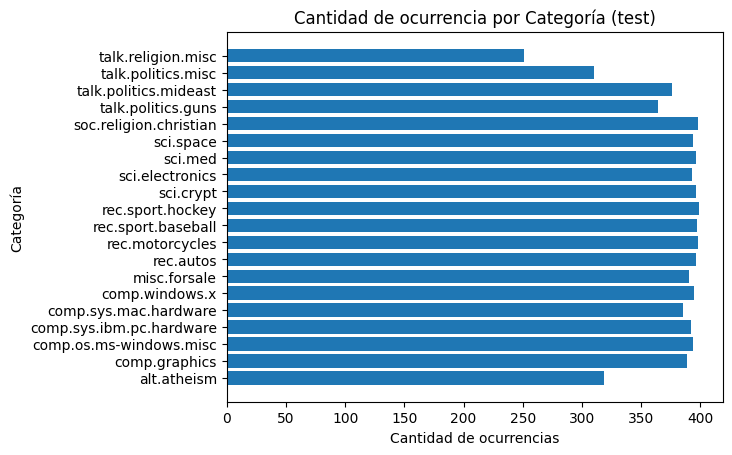

In [ ]:
plt.barh(newsgroups_test.target_names, counts)
plt.xlabel('Cantidad de ocurrencias')
plt.ylabel('Categoría')
plt.title('Cantidad de ocurrencia por Categoría (test)')
plt.show()

## ***Resolución ejercicio 3***

#### ***Enunciado***

- Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación (f1-score macro) en el conjunto de datos de test.
- Considerar cambiar parámteros de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial y ComplementNB.

#### Funciones de utilidad

Se definen las siguientes funciones de utilidad:

- `clasificar_documentos`: esta función permite realizar la clasificación de unos documentos de **test** en función de un clasificador del tipo `ZeroShotClassifier`, `MultinomialNB` o `ComplementNB`, devolviendo el `f1-score` ***macro***.
- `optimizar_hiperparametros`: permite optimizar los hiperparámetros indicados de un modelo del tipo `MultinomialNB` o `ComplementNB`, para un conjunto de **train** y un vectorizador **TF-Idf** dados.
- `optimizar_y_clasificar`: se encarga de llamar a las funciones `optimizar_hiperparametros` y `clasificar_documentos`, dados unos parámetros determinados.

In [ ]:
def clasificar_documentos(train: Bunch, test: Bunch, vectorizer: TfidfVectorizer,
                          classifier: ZeroShotClassifier | MultinomialNB | ComplementNB) -> float:
  """
  Realiza una clasificación de documentos vectorizados, devolviendo la métrica
  f1-score (macro).

  Args:
    train (Bunch): corpus con documentos de train, junto sus clases.
    test (Bunch): corpus con documentos de test, junto sus clases.
    vectorizer (TfidfVectorizer): vectorizador de documentos.
    classifier (ZeroShotClassifier | MultinomialNB | ComplementNB): clasificador
      a implementar, puede ser ZeroShotClassifier, MultinomialNB o ComplementNB.
  Returns:
    float: f1-score (con average='macro').
  """

  X_train = vectorizer.fit_transform(train.data)
  y_train = train.target

  X_test = vectorizer.transform(test.data)
  y_test = test.target

  classifier.fit(X=X_train, y=y_train)
  y_pred = classifier.predict(X=X_test)

  f1 = f1_score(y_test, y_pred, average='macro')

  return f1


In [ ]:
def optimizar_hiperparametros(train: Bunch, vectorizer: TfidfVectorizer,
                              model: MultinomialNB | ComplementNB,
                              param_grid: Any, cv: int = 5,
                              scoring: str = "f1_macro") -> GridSearchCV:
  """
  Optimiza un modelo del tipo Naive Bayes
  f1-score (macro).

  Args:
    train (Bunch): corpus con documentos de train, junto sus clases.
    vectorizer (TfidfVectorizer): vectorizador de documentos.
    model (ZeroShotClassifier | MultinomialNB | ComplementNB): modelo cuyos
      hiperparámetros serán optimizados. Puede ser MultinomialNB o ComplementNB.
    param_grid (Any): diccionario de hiperparámetros a optimizar.
    cv (int): cantidad de cross-validation a implementar. Por defecto es 5.
    scoring (str): métrica sobre la cual se optimiza. Por defecto es `f1_macro`.
  Returns:
    (GridSearchCV): resultado de la búsqueda de hiperparámetros.
  """
  X_train = vectorizer.fit_transform(train.data)
  y_train = train.target

  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv,
                             scoring=scoring)
  grid_search.fit(X_train, y_train)

  return grid_search

In [ ]:
def optimizar_y_clasificar(train: Bunch, test: Bunch,
                           vectorizer: TfidfVectorizer,
                           modelClass: type,
                           param_grid: Any, cv: int = 5,
                           scoring: str = "f1_macro") -> float:
  """
  Optimiza y clasifica un modelo. Devuelve una métrica de clasificación.

  Args:
    train (Bunch): corpus con documentos de train, junto sus clases.
    test (Bunch): corpus con documentos de test, junto sus clases.
    vectorizer (TfidfVectorizer): vectorizador de documentos.
    modelClass (type): Tipo del modelo sobre el cual trabajar. Debe ser
      MultinomialNB o ComplementNB
    param_grid (Any): diccionario de hiperparámetros a optimizar.
    cv (int): cantidad de cross-validation a implementar. Por defecto es 5.
    scoring (str): métrica sobre la cual se optimiza. Por defecto es `f1_macro`.
  Returns:
    (float): Métrica definida en scoring.
  """
  if not issubclass(modelClass, MultinomialNB) and not issubclass(modelClass, ComplementNB):
    raise TypeError("El parámetro modelClass debe ser MultinomialNB o ComplementNB")

  model = modelClass()
  grid_search = optimizar_hiperparametros(train=train,
                                          vectorizer=vectorizer,
                                          model=model, param_grid=param_grid,
                                          cv=cv, scoring=scoring)

  print("Mejores hiperparámetros:", grid_search.best_params_)
  print("Mejor f1-score (macro):", grid_search.best_score_)

  if issubclass(modelClass, MultinomialNB):
    best_model = MultinomialNB(alpha=grid_search.best_params_["alpha"],
                               fit_prior=grid_search.best_params_["fit_prior"])
  else:
    best_model = ComplementNB(alpha=grid_search.best_params_["alpha"],
                              fit_prior=grid_search.best_params_["fit_prior"],
                              norm=grid_search.best_params_["norm"])

  f1 = clasificar_documentos(train=train, test=test, vectorizer=vectorizer,
                             classifier=best_model)

  return f1

#### Gráficos - Frecuencia de tipo de documentos

En esta sección se realizan gráficos de ocurrencia por categoría en Train y test a fin de analizar si las clases están desbalanceadas.

Como se puede observar, tanto en `train` como en `test` hay desbalance, siendo las clases más afectadas `talk.religion.misc` y `talk.politics.misc`.

In [103]:
unique_values_train, counts_train = np.unique(newsgroups_train.target, return_counts=True)
unique_values_test, counts_test = np.unique(newsgroups_test.target, return_counts=True)

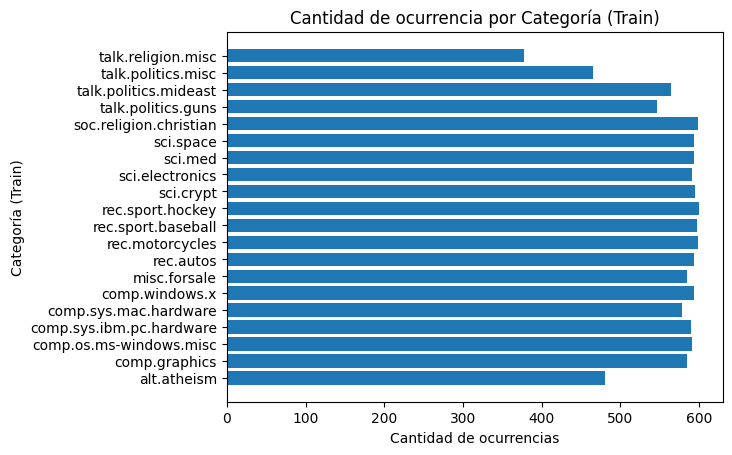

In [104]:
plt.barh(newsgroups_train.target_names, counts_train)
plt.xlabel('Cantidad de ocurrencias')
plt.ylabel('Categoría (Train)')
plt.title('Cantidad de ocurrencia por Categoría (Train)')
plt.show()

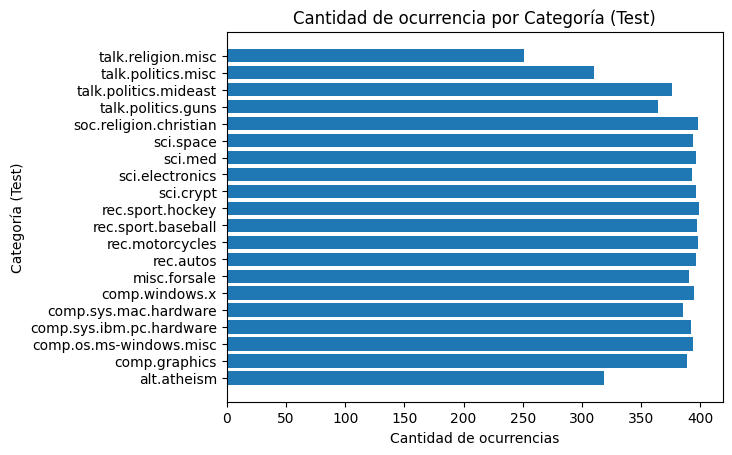

In [ ]:
plt.barh(newsgroups_test.target_names, counts_test)
plt.xlabel('Cantidad de ocurrencias')
plt.ylabel('Categoría (Test)')
plt.title('Cantidad de ocurrencia por Categoría (Test)')
plt.show()

#### Vectorizadores

En esta sección se crean tres configuraciones para un vectorizador del tipo [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

1) La configuración `defaultVectorizer` corresponde al vectorizador con los parámetros por defecto.
2) La configuración `sublinearTFVectorizer` corresponde al vectorizador con el parámetro `sublinear_tf` en ***True***
    - De esta manera, se reemplaza el término `TF` por $1 + log(tf)$, es decir, se aplica ***sublinear scaling***.
    - Esto permite moderar el peso de los términos que aparecen de manera frecuentes, ayudando a mitigar el bias en los documentos.
    - Fuente: [TF-IDF - understanding in NLP](https://zilliz.com/learn/tf-idf-understanding-term-frequency-inverse-document-frequency-in-nlp#Advanced-Considerations)
3) La configuración `noIdfVectorizer`, la cual configura el parámetro `use_idf` en ***False***:
    - De esta manera, el término $IDF(t)$ sería igual a $1$, es decir, la fórmula $TF-IDF = TF x IDF$ queda como $TF-IDF = TF$.
    - Solamente consideramos la frecuencia de los términos.

La idea es explorar estas tres configuraciones en las siguientes etapas, junto a clasificadores del tipo `MultinomialNB` y `ComplementNB`.

<!-- $1=1$. -->

In [ ]:
defaultVectorizer = TfidfVectorizer()
sublinearTFVectorizer = TfidfVectorizer(sublinear_tf=True)
noIdfVectorizer = TfidfVectorizer(use_idf=False)

#### Multinomial Naive Bayes

En esta sección se explora el clasificador Multinomial Naive Bayes mediante la clase [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) de scikit-learn.

Mediante éste, se realizarán clasificaciones sobre el *corpus* de test, luego de haber realizado un entrenamiento o [fit](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB.fit) sobre el *corpus* de train.

Primero, se estudia al clasificador con su configuración por defecto, utilizando los tres vectorizadores creados en la sección de `Vectorizadores`.

Luego, se realiza una optimización de hiperparámetros sobre este clasificador, una vez por cada tipo de vectorizador.

En cada experimento se utiliza la métrica de `f1-score` ***macro***.

Finalmente, se compararon los resultados de cada prueba, obteniendo los siguientes valores:

| Clasificador | Alpha | Fit_prior | Vectorizador | F1-score (`macro`) |
| --- | --- | --- | --- | --- |
| Multinomial NB | 1.0 (default) | True (default) | **TF IDF** default | $0.5854$ |
| Multinomial NB | 1.0 (default) | True (default) | **TF IDF** `sublinearTFVectorizer` | $0.5860$ |
| Multinomial NB | 1.0 (default) | True (default) | **TF IDF** `noIdfVectorizer` | $0.4716$ |
| Multinomial NB | $0.01$ | $False$ | **TF IDF** default | $0.6895$ |
| Multinomial NB |  $0.01$ | $False$ | **TF IDF** `sublinearTFVectorizer` | $0.684$ |
| Multinomial NB |  $0.001$ | $False$ | **TF IDF** `noIdfVectorizer` | $0.6801$ |

La combinación de *Clasificador* y *Vectorizador* que mejor `f1-score` obtuvo fue:
- vectorizador `TF-IDF` por defecto.
- `Multinomial NB` con optimización mediante GridSearch
  - `alpha` igual a $0.01$.
  - `Fit_prior` igual a $False$.

La métrica final de f1-score macro fue de $0.6895$.

In [ ]:
defaultMultinomial = MultinomialNB()

En las siguientes celdas se realizan las clasificaciones del modelo `MultinomialNB` con los parámetros por defecto, una vez por cada `vectorizador`.

In [ ]:
f1_default_vectorizer_default_multinomial = clasificar_documentos(train=newsgroups_train, test=newsgroups_test, vectorizer=defaultVectorizer, classifier=defaultMultinomial)
f1_sublinear_vectorizer_default_multinomial = clasificar_documentos(train=newsgroups_train, test=newsgroups_test, vectorizer=sublinearTFVectorizer, classifier=defaultMultinomial)
f1_noIdf_vectorizer_default_multinomial = clasificar_documentos(train=newsgroups_train, test=newsgroups_test, vectorizer=noIdfVectorizer, classifier=defaultMultinomial)

In [ ]:
print(f"F1-score para Multinomial Naive Bayes, con TfidfVectorizer (parámetros por default): {f1_default_vectorizer_default_multinomial}")
print(f"F1-score para Multinomial Naive Bayes, con TfidfVectorizer (sublinear_tf = True): {f1_sublinear_vectorizer_default_multinomial}")
print(f"F1-score para Multinomial Naive Bayes, con TfidfVectorizer (use)idf = False): {f1_noIdf_vectorizer_default_multinomial}")

F1-score para Multinomial Naive Bayes, con TfidfVectorizer (parámetros por default): 0.5854345727938506
F1-score para Multinomial Naive Bayes, con TfidfVectorizer (sublinear_tf = True): 0.5859647447228136
F1-score para Multinomial Naive Bayes, con TfidfVectorizer (use)idf = False): 0.4715859558342732


A la hora de optimizar hiperparámetros para el clasificador `MultinomialNB` se opta por estudiar los siguientes parámetros mediante ***Grid-Search***:

- `alpha`
  - Es un parámetro utilizado para controlar el `smoothing`, es decir, controlar la sensibilidad del modelo.
  - Un valor ***alto*** de alpha incrementa el `smoothing`, lo cual reduce la sensibilidad del modelo y previene el `overfitting` en los datos de entrenamiento, pero puede producir `underfitting`.
  - De la misma manera, un valor ***bajo*** disminuye el `smoothing`, lo cual hace al modelo más sensible a los datos de entradas, es decir, puede provocar `overfitting`.
  - En scikit-learn, se utiliza `1.0` por defecto.
  - Se estudian los siguientes valores: `0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0`.
  - Fuentes:
    - [Alpha hyperparameter and the fundamental tradeoff](https://bait509-ubc.github.io/BAIT509/lectures/lecture6.html#alpha-hyperparameter-and-the-fundamental-tradeoff).
    - [Stackoverflow - Alpha setting](https://stackoverflow.com/questions/33830959/multinomial-naive-bayes-parameter-alpha-setting-scikit-learn#:~:text=1944%2015-,Comments,11).
- `fit_prior`
  - Por defecto es `True`. Esto quiere decir que el modelo aprende las probabilidades `A priori` de cada clase.
  - En caso de ser `False`, utiliza una distribución ***Uniforme*** `A priori`.
  - Se estudian los valores `True` y `False`.    

In [ ]:
paramsMultinomialNB = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'fit_prior': [True, False],
}

In [ ]:
f1 = optimizar_y_clasificar(train=newsgroups_train, test=newsgroups_test,
                       vectorizer=defaultVectorizer, modelClass=MultinomialNB,
                       param_grid=paramsMultinomialNB)

print(f"F1-score para Multinomial Naive Bayes con optimización de hiperparámetros: {f1}")

Mejores hiperparámetros: {'alpha': 0.01, 'fit_prior': False}
Mejor f1-score (macro): 0.7601998967577746
F1-score para Multinomial Naive Bayes con optimización de hiperparámetros: 0.6895480073763225


In [ ]:
f1 = optimizar_y_clasificar(train=newsgroups_train, test=newsgroups_test,
                       vectorizer=sublinearTFVectorizer, modelClass=MultinomialNB,
                       param_grid=paramsMultinomialNB)

print(f"F1-score para Multinomial Naive Bayes con optimización de hiperparámetros: {f1}")

Mejores hiperparámetros: {'alpha': 0.01, 'fit_prior': False}
Mejor f1-score (macro): 0.7562093721950356
F1-score para Multinomial Naive Bayes con optimización de hiperparámetros: 0.683932559382104


In [ ]:
f1 = optimizar_y_clasificar(train=newsgroups_train, test=newsgroups_test,
                       vectorizer=noIdfVectorizer, modelClass=MultinomialNB,
                       param_grid=paramsMultinomialNB)


print(f"F1-score para Multinomial Naive Bayes con optimización de hiperparámetros: {f1}")

Mejores hiperparámetros: {'alpha': 0.001, 'fit_prior': False}
Mejor f1-score (macro): 0.7493339731384524
F1-score para Multinomial Naive Bayes con optimización de hiperparámetros: 0.6800779263560974


#### Complement Naive Bayes

En esta sección se explora el clasificador Complement Naive Bayes mediante la clase [ComplementNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB.fit) de scikit-learn.

Tal como se menciona en el artículo [Mastering Naive Bayes: a comprehensive python guide to probabilistic classification](https://medium.com/@patwariraghottam/mastering-naive-bayes-a-comprehensive-python-guide-to-probabilistic-classification-b7fe67c6763f), `Complement` Naive Bayes es una variante de `Multinomial` Naive Bayes diseñada para manejar/tratar datasets desbalanceados.

Tal como se muestra en la sección `Gráficos - Frecuencia de tipo de documentos`, los datasets de train y tests presentan cierto desbalance.

Podemos asumir entonces que este clasificador tendrá mejores métricas que las obtenidas para `Multinomial Naive Bayes`.

Mediante éste, se realizarán clasificaciones sobre el *corpus* de test, luego de haber realizado un entrenamiento o [fit](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB.fit) sobre el *corpus* de train.

Primero, se estudia al clasificador con su configuración por defecto, utilizando los tres vectorizadores creados en la sección de `Vectorizadores`.

Luego, se realiza una optimización de hiperparámetros sobre este clasificador, una vez por cada tipo de vectorizador.

En cada experimento se utiliza la métrica de `f1-score` ***macro***.

Finalmente, se compararon los resultados de cada prueba, obteniendo los siguientes valores:

| Clasificador | Alpha | Fit_prior | Norm | Vectorizador | F1-score (`macro`) |
| --- | --- | --- | --- | --- | --- |
| Complement NB | 1.0 (default) | True (default) | False (default) | **TF IDF** default | $0.6930$ |
| Complement NB | 1.0 (default) | True (default) | False (default) | **TF IDF** `sublinearTFVectorizer` | $0.6920$ |
| Complement NB | 1.0 (default) | True (default) | False (default) | **TF IDF** `noIdfVectorizer` | $0.6677$ |
| Complement NB | $0.1$ | $True$ | $False$ | **TF IDF** default | $0.6954$ |
| Complement NB | $0.1$ | $True$ | $False$ | **TF IDF** `sublinearTFVectorizer` | $0.6927$ |
| Complement NB | $0.01$ | $True$ | $False$ | **TF IDF** `noIdfVectorizer` | $0.6907$ |

La combinación de *Clasificador* y *Vectorizador* que mejor `f1-score` obtuvo fue:
- vectorizador `TF-IDF` por defecto.
- `Complement NB` con optimización mediante GridSearch
  - `alpha` igual a $0.1$.
  - `Fit_prior` igual a $True$.
  - `Norm` igual a $False$.

La métrica final de f1-score macro fue de $0.6954$.

In [ ]:
defaultComplement = ComplementNB()

In [ ]:
f1_default_vectorizer_default_complement = clasificar_documentos(train=newsgroups_train, test=newsgroups_test, vectorizer=defaultVectorizer, classifier=defaultComplement)
f1_sublinear_vectorizer_default_complement = clasificar_documentos(train=newsgroups_train, test=newsgroups_test, vectorizer=sublinearTFVectorizer, classifier=defaultComplement)
f1_noIdf_vectorizer_default_complement = clasificar_documentos(train=newsgroups_train, test=newsgroups_test, vectorizer=noIdfVectorizer, classifier=defaultComplement)

In [ ]:
print(f"F1-score para Complement Naive Bayes, con TfidfVectorizer (parámetros por default): {f1_default_vectorizer_default_complement}")
print(f"F1-score para Complement Naive Bayes, con TfidfVectorizer (sublinear_tf = True): {f1_sublinear_vectorizer_default_complement}")
print(f"F1-score para Complement Naive Bayes, con TfidfVectorizer (use)idf = False): {f1_noIdf_vectorizer_default_complement}")

F1-score para Complement Naive Bayes, con TfidfVectorizer (parámetros por default): 0.692953349950875
F1-score para Complement Naive Bayes, con TfidfVectorizer (sublinear_tf = True): 0.6920430313518313
F1-score para Complement Naive Bayes, con TfidfVectorizer (use)idf = False): 0.6677142139539859


In [ ]:
paramsComplementNB  = {
    'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'fit_prior': [True, False],
    'norm': [True, False]
}

In [ ]:
f1 = optimizar_y_clasificar(train=newsgroups_train, test=newsgroups_test,
                       vectorizer=defaultVectorizer, modelClass=ComplementNB,
                       param_grid=paramsComplementNB)
print(f"F1-score para Complement Naive Bayes con optimización de hiperparámetros: {f1}")

Mejores hiperparámetros: {'alpha': 0.1, 'fit_prior': True, 'norm': False}
Mejor f1-score (macro): 0.7656097292010164
F1-score para Complement Naive Bayes con optimización de hiperparámetros: 0.6953652590540836


In [ ]:
f1 = optimizar_y_clasificar(train=newsgroups_train, test=newsgroups_test,
                       vectorizer=sublinearTFVectorizer, modelClass=ComplementNB,
                       param_grid=paramsComplementNB)

print(f"F1-score para Complement Naive Bayes con optimización de hiperparámetros: {f1}")

Mejores hiperparámetros: {'alpha': 0.1, 'fit_prior': True, 'norm': False}
Mejor f1-score (macro): 0.7653089638955547
F1-score para Complement Naive Bayes con optimización de hiperparámetros: 0.6926823186826047


In [ ]:
f1 = optimizar_y_clasificar(train=newsgroups_train, test=newsgroups_test,
                       vectorizer=noIdfVectorizer, modelClass=ComplementNB,
                       param_grid=paramsComplementNB)

print(f"F1-score para Complement Naive Bayes con optimización de hiperparámetros: {f1}")

Mejores hiperparámetros: {'alpha': 0.01, 'fit_prior': True, 'norm': False}
Mejor f1-score (macro): 0.7634908309920609
F1-score para Complement Naive Bayes con optimización de hiperparámetros: 0.6907691168522462


#### Comparación de clasificadores y ***conclusiones***

En este ejercicio se estudiaron dos clasificadores nuevos: `Multinomial Naive Bayes` y `Complement Naive Bayes`.

Se realizaron varias pruebas de estos clasificadores, junto con los vectorizadores definidos en la sección `vectorizadores`, como así también optimizando hiperparámetros de los mismos.

Al evaluar estos clasificadores con la métrica de `f1-score (macro)`, se obtuvieron métricas superiores a la obtenida en el modelo `Zero-shot`.

Estas son las métricas de los modelos estudiados:

| Modelo | Vectorizador | Optimización de hiperparámetros? | F1-score (macro) |
| --- | --- | --- | --- |
| Zero-Shot | TF-IDF (default) | No | $0.5050$ |
| Multinomial NB | TF-IDF (default) | Si | $0.6895$ |
| Complement NB | TF-IDF (default) | Si | $0.6954$ |

Tal como se observa en la tabla, el modelo con mejor métrica fue `Complement NB`, el cual supera ligeramente al `Multinomial NB` dado a que este *trata* mejor el desbalance de clases.
- ***Fuente***: [Mastering Naive Bayes: a comprehensive python guide to probabilistic classification](https://medium.com/@patwariraghottam/mastering-naive-bayes-a-comprehensive-python-guide-to-probabilistic-classification-b7fe67c6763f)
- ***Nota***: recordar que en la sección `Gráficos - Frecuencia de tipo de documentos` se muestra que tanto en `train` como en `test` hay clases desbalanceadas.

De esta manera se demuestra que:
- `Zero-Shot` es un buen modelo para hacer un *baseline*, pero no es suficiente para hacer una buena clasificación.
- Los modelos `Multinomial NB` y `Complement NB` tendrán mejor métrica que `Zero-Shot`.
- Tanto para `Multinomial NB` como `Complement NB` resulta beneficioso realizar optimización de hiperparámetros a fin de mejorar la métrica final.
- `Complement NB` tendrá mejor métrica que `Multinomial NB` en casos de datasets desbalanceados.
  - En nuestro caso de estudio, el desbalance es relativamente bajo. A partir de esto se puede explicar la diferencia relativamente baja en las métricas de F1-score (macro) de ambos modelos.

## ***Resolución ejercicio 4***

### ***Enunciado***

- Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
- Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares.

**Elegir las palabras MANUALMENTE para evitar la aparición de términos poco interpretables**.


#### Matriz término-documento

La matriz `término-documento` se obtiene al transponer la matriz `documento-término`.

Para ello, primero se instancia un [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), que nos permite obtener la primer matriz a partir del dataset de *train*.

Una vez obtenida la matriz `documento-término`, llamamos al método `T` que permite trasponerla, lo que a su vez permite obtener la matriz `término-documento` deseada.

In [ ]:
tfidVectorizer_04 = TfidfVectorizer()

In [ ]:
documento_termino_train = tfidVectorizer_04.fit_transform(newsgroups_train.data)

In [ ]:
termino_documento_train = documento_termino_train.T

In [ ]:
termino_documento_train

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 1103627 stored elements and shape (101631, 11314)>

#### Elección de términos

El vectorizador Tf-idf (*tfidfVectorizer_04* en este caso) tiene el atributo `vocabulary_`, el cual consiste en un *mapeo de términos a índices de features*.

A partir del mismo se eligen los siguientes términos a estudiar:

| Término | Índice |
| --- | --- |
| benzocaine | 22402 |
| mitra | 62165 |
| superencrypt | 86440 |
| winhelp | 96801 |
| megatons | 60786 |

In [ ]:
terminos = ["benzocaine", "mitra", "superencrypt", "winhelp", "megatons"]

title = "| Término | Índice |"
print(title)
print("="*len(title))
for t in terminos:
  print(f"| {t} | {tfidVectorizer_04.vocabulary_[t]} |")

| Término | Índice |
| benzocaine | 22402 |
| mitra | 62165 |
| superencrypt | 86440 |
| winhelp | 96801 |
| megatons | 60786 |


### Funciones de utilidad

Se define la función de utilidad `imprimir_informe_punto_4`, la cual muestra el informe correspondiente al estudio de un término de una matriz término-documento.

Se utilizan dentro de esta función otras funciones definidas en la sección `Resolución ejercicio 1`.

In [ ]:
def imprimir_informe_punto_4(termino_documento: csc_matrix, termino: str,
                             vectorizer: TfidfVectorizer, K: int = 5) -> str:
  """
  Imprime el informe del punto 4 para cada uno de los términos a estudiar.

  Args:
    termino_documento (csc_matrix): Matriz término documento.
    termino (str): término a estudiar.
    vectorizer (TfidfVectorizer): vectorizador utilizado.
    K (int): Cantidad de términos similares a estudiar. Por defecto es 5.

  Returns:
    (str): informe detallado de los K términos similares al término indicado.
      Se utiliza similitud coseno.
  """
  idx2word = {v: k for k,v in vectorizer.vocabulary_.items()}
  idx = vectorizer.vocabulary_[termino]
  similar_words, similar_words_idx = get_k_most_similar_documents(matriz_dt=termino_documento, idx=idx, K=K)

  template = f"En esta sección se estudia el término ***{termino}***, cuyo índice en la matriz término documento es ${idx}$.\n\n"
  template += f"A continuación, se detallan los {K} términos con mayor similitud coseno.\n\n"

  tabla = "| Término | Índice | Similitud Coseno |\n"
  tabla += "| --- | --- | --- |\n"

  for i in range(len(similar_words)):
    similar_idx = similar_words_idx[i]
    similar_term = idx2word[similar_idx]
    similitud = similar_words[i]
    tabla += f"| {similar_term} | {similar_idx} | ${similitud}$ |\n"

  return template + tabla


#### Término: ***benzocaine***

En esta sección se estudia el término ***benzocaine***, cuyo índice en la matriz término documento es $22402$.

A continuación, se detallan los 5 términos con mayor similitud coseno.

| Término | Índice | Similitud Coseno |
| --- | --- | --- |
| burrow | 24746 | $1.0$ |
| waistband | 95661 | $1.0$ |
| deet | 32434 | $1.0$ |
| chig | 27006 | $1.0$ |
| pests | 70906 | $1.0$ |

Se observa que los 5 términos tienen todos la misma similutd coseno, la cual es la máxima posible ($1$).

Esto indica que los términos aparecerían todos en los mismos documentos que la palabra ***benzocaine***.

El término ***benzocaine*** se refiere a la benzocaína, un anestésico local que se utiliza para aliviar dolores leves.

Por su parte:
- `burrow` significa *madriguera*/*escondrijo*.
- `chig` posiblemente se referiera a la abreviación del término *chigger* o *acaro*.
- `pests` significa *plagas*.

Es decir, esos tres términos pueden relacionarse a la *benzocaina* ya que éste anestésico podría aplicarse para aliviar picaduras de *ácaros* u otras *plagas* (*madriguera* se relacionaría con éstos últimos).

Respecto a *waistband* (*pretina*) y *deet* (según la IA de Google, *DEET es la abreviatura de N,N-dietil-meta-toluamida*), no se encuentran relación directa con ***benzocaine*** (aunque esto podría ser desconocimiento mío).

In [ ]:
termino = terminos[0]
informe = imprimir_informe_punto_4(termino_documento=termino_documento_train,
                         termino=termino, vectorizer=tfidVectorizer_04)
print(informe)

En esta sección se estudia el término ***benzocaine***, cuyo índice en la matriz término documento es $22402$.

A continuación, se detallan los 5 términos con mayor similitud coseno.

| Término | Índice | Similitud Coseno |
| --- | --- | --- |
| burrow | 24746 | $1.0$ |
| waistband | 95661 | $1.0$ |
| deet | 32434 | $1.0$ |
| chig | 27006 | $1.0$ |
| pests | 70906 | $1.0$ |



#### Término: ***mitra***

En esta sección se estudia el término ***mitra***, cuyo índice en la matriz término documento es $62165$.

A continuación, se detallan los 5 términos con mayor similitud coseno.

| Término | Índice | Similitud Coseno |
| --- | --- | --- |
| rediscovered | 76813 | $1.0$ |
| impaling | 49252 | $1.0$ |
| deities | 32615 | $1.0$ |
| cybele | 31285 | $1.0$ |
| antly | 18877 | $1.0$ |

Nuevamente, se observa que todos los términos tienen similitud coseno máxima, lo que significa que los términos aparecen en los mismos documentos que el término de estudio.

Respecto al término de estudio ***Mitra***, éste se refiere a una antigua deidad persa de los contratos, la luz y la justicia.

Significado de términos similares:
- `rediscovered` significa *redescubierta*.
- `impaling` significa *empalando*.
- `deities` significa *deidades*.
- `Cybele` puede referirse a la diosa de la fertilidad frigia, Cibeles, conocida como la Gran Madre, cuyo culto se extendió a la antigua Grecia y Roma.
- `Antly` -> no se encontró traducción.

Los términos `deities` y `Cybele` se pueden relacionar a `Mitra` ya que hablan de deidades.

`Rediscovered` puede asociarse a `Mitra` en algún documento que hable sobre como fue *redescubierta* por historiadores.

`Impaling` puede referirse a la estatua de [Mitra Matando al toro](https://es.wikipedia.org/wiki/Mitra_matando_al_toro) (*mitra impaling the bull*).


In [ ]:
termino = terminos[1]
informe = imprimir_informe_punto_4(termino_documento=termino_documento_train,
                         termino=termino, vectorizer=tfidVectorizer_04)
print(informe)

En esta sección se estudia el término ***mitra***, cuyo índice en la matriz término documento es $62165$.

A continuación, se detallan los 5 términos con mayor similitud coseno.

| Término | Índice | Similitud Coseno |
| --- | --- | --- |
| rediscovered | 76813 | $1.0$ |
| impaling | 49252 | $1.0$ |
| deities | 32615 | $1.0$ |
| cybele | 31285 | $1.0$ |
| antly | 18877 | $1.0$ |



#### Término: ***superencrypt***

En esta sección se estudia el término ***superencrypt***, cuyo índice en la matriz término documento es $86440$.

A continuación, se detallan los 5 términos con mayor similitud coseno.

| Término | Índice | Similitud Coseno |
| --- | --- | --- |
| superencrypted | 86441 | $1.0$ |
| desiring | 33105 | $0.9873825469632354$ |
| impose | 49357 | $0.5973588048196898$ |
| internals | 50569 | $0.43138383417773013$ |
| traffic | 89842 | $0.3131031162733452$ |

Como se puede observar, el término con mayor similitud coseno es `superencrypted`, con un valor de $1$, es decir, se encuentra en los mismos documentos que el término de estudio. Esto tiene sentido porque `superencrypt`***ed*** puede referirse al pasado de ***superencrypt***, o al adjetivo asociado a dicho término.

El segundo término es `desiring`, el cual tiene una similitud bastante alta ($0.9874$), lo cual indica que *comparten* casi todos los documentos (es decir, en donde aparece el término ***superencrypt*** también aparece `desiring`).

Los siguientes términos, tienen una similitud relativamente baja, siendo la mayor de $0.60$. Ésta corresponde al término `impose`, el cual significa *imponer*.

Como conclusión podemos decir que en este caso se encontraron términos con similitud baja, es decir, que son poco comúnes a ser utilizados en un mismo documento que con el término ***superencrypt***.

In [ ]:
termino = terminos[2]
informe = imprimir_informe_punto_4(termino_documento=termino_documento_train,
                         termino=termino, vectorizer=tfidVectorizer_04)
print(informe)

En esta sección se estudia el término ***superencrypt***, cuyo índice en la matriz término documento es $86440$.

A continuación, se detallan los 5 términos con mayor similitud coseno.

| Término | Índice | Similitud Coseno |
| --- | --- | --- |
| superencrypted | 86441 | $1.0$ |
| desiring | 33105 | $0.9873825469632354$ |
| impose | 49357 | $0.5973588048196898$ |
| internals | 50569 | $0.43138383417773013$ |
| traffic | 89842 | $0.3131031162733452$ |



#### Término: ***winhelp***

En esta sección se estudia el término ***winhelp***, cuyo índice en la matriz término documento es $96801$.

A continuación, se detallan los 5 términos con mayor similitud coseno.

| Término | Índice | Similitud Coseno |
| --- | --- | --- |
| mwindows | 64346 | $1.0$ |
| winos2 | 96831 | $1.0$ |
| infects | 49861 | $0.9895432787696364$ |
| virus | 94469 | $0.5545442610780615$ |
| remedies | 77349 | $0.5339826701903861$ |

El término de estudio ***winhelp*** se refiere a la ayuda de *Windows*.

Por este motivo, términos como `mwindows`, `winos2` (Win OS 2), e `infects` tengan una similitud coseno alta ($1$ para los primeros dos términos, y $0.99$ para el tercer término).

El término `virus` tiene una similitud coseno de $0.55$ con ***winhelp***, es decir, `virus` no siempre aparece en los documentos donde se menciona a ***winhelp***.

Por último, `remedies` (soluciona), tiene una similitud de $0.53$ con `winhelp`, es decir, que `remedies` no siempre aparece en los documentos donde se menciona a ***winhelp***.

In [ ]:
termino = terminos[3]
informe = imprimir_informe_punto_4(termino_documento=termino_documento_train,
                         termino=termino, vectorizer=tfidVectorizer_04)
print(informe)

En esta sección se estudia el término ***winhelp***, cuyo índice en la matriz término documento es $96801$.

A continuación, se detallan los 5 términos con mayor similitud coseno.

| Término | Índice | Similitud Coseno |
| --- | --- | --- |
| mwindows | 64346 | $1.0$ |
| winos2 | 96831 | $1.0$ |
| infects | 49861 | $0.9895432787696364$ |
| virus | 94469 | $0.5545442610780615$ |
| remedies | 77349 | $0.5339826701903861$ |



#### Término: ***Megatons***

En esta sección se estudia el término ***megatons***, cuyo índice en la matriz término documento es $60786$.

A continuación, se detallan los 5 términos con mayor similitud coseno.

| Término | Índice | Similitud Coseno |
| --- | --- | --- |
| impelling | 49280 | $1.0$ |
| barium | 21646 | $1.0$ |
| irradiated | 51081 | $1.0$ |
| spacedrive | 84105 | $1.0$ |
| gammas | 42614 | $1.0$ |

Nuevamente estamos frente a un caso en donde los $5$ términos estudiados tienen similitud coseno de $1$, es decir, que en los documentos donde aparece ***megatons*** también aparecen estos términos.

Significados:
- `impelling` significa *impulsando*.
- `barium` significa *Bario*.
- `irradiated` significa *Irradiado/a*.
- `spacedrive` significa *unidad espacial*.
- `Gammas` podría hacer referencia al concepto de radiación gamma.

Por su parte, ***megatons*** significa *megatones*, una unidad de energía que se utiliza para expresar la potencia explosiva de bombas o proyectiles nucleares. Es decir, los textos en donde aparecen dichos términos pueden ser del tipo científico, en donde hablan de conceptos relacionados a la energía nuclear.

In [ ]:
termino = terminos[4]
informe = imprimir_informe_punto_4(termino_documento=termino_documento_train,
                         termino=termino, vectorizer=tfidVectorizer_04)
print(informe)

En esta sección se estudia el término ***megatons***, cuyo índice en la matriz término documento es $60786$.

A continuación, se detallan los 5 términos con mayor similitud coseno.

| Término | Índice | Similitud Coseno |
| --- | --- | --- |
| impelling | 49280 | $1.0$ |
| barium | 21646 | $1.0$ |
| irradiated | 51081 | $1.0$ |
| spacedrive | 84105 | $1.0$ |
| gammas | 42614 | $1.0$ |



#### Conclusiones del punto 4

En esta sección se estudió nuevamente el concepto de `similitud_coseno`, pero aplicado a matriz `término-documento` en vez de una matriz `documento-término` como se realizó en el punto 1.

Esto permite determinar que tan similares son dos términos en función de los documentos que *comparten*, o mejor dicho, en los documentos en donde aparecen (siempre hablando sobre un ***corpus*** en particular).